In [257]:
# base, plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Keras, classification
import keras
from keras import models
from keras import layers
from sklearn.svm import SVC
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

# suppress warning outputs
import warnings
warnings.filterwarnings('ignore')

In [258]:
# define gestures
gestures = [0, 1, 2, 3, 4, 5, 6, 7]
n_gestures = len(gestures)
n_samples = 6000
n_channels = 8
fs = 200 # sample frequency

# use first 30 seconds of the signal (entire signal)
samp_for_dataset = 30 * fs

# initialize empty datasets
data, data_labels = np.empty((0, n_channels)), np.empty((0, 1))
arv_data, arv_labels = np.empty((0, n_channels)), np.empty((0, 1))

# 
# USING ALL AVAILABLE DATA
# 

folders = [ 'P1/S1/',
            'P1/S2/',
            'P1/S3/',
            'P1/S4/',
            'P2/S1/',
            'P2/S2/',
            'P2/S3/',
            'P2/S4/',
            'P3/S1/',
            'P3/S2/',
            'P3/S3/',
            'P3/S4/',
            ]

# preprocessing
def calculate_arv(file_data, window_size, samples, channels):
    new_rows = samples // window_size
    arv_data = np.zeros((new_rows, channels), dtype=np.float32)
    for channel in range(channels):
        start = 0
        end = window_size
        for sample in range(new_rows):
            arv_data[sample][channel] = 1/window_size * sum(abs(file_data[start:end, channel]))
            # update moving window
            start = end
            end += window_size
    
    return arv_data


window_size = 20
for folder in folders:
    for i_gesture in range(n_gestures):
        path = f'./signals/{folder}{i_gesture}.csv'
        try:
            # read raw data from .csv file
            temp_data = pd.read_csv(path, delimiter=',', header=None).to_numpy()
            # read labels
            data_labels = np.append(data_labels, np.full((samp_for_dataset, 1), i_gesture))
            data = np.append(data, temp_data, axis=0)

            # preprocessing
            arv = calculate_arv(temp_data, window_size, n_samples, n_channels)
            arv_data = np.append(arv_data, arv, axis=0)
        except:
            print("error occurred while processing data")
            pass


# compute corresponding labels for ARV preprocessed data
for i in range(window_size, data.shape[0]+1, window_size):
    label = np.bincount(data_labels[i-window_size:i].astype(int).flatten()).argmax()
    arv_labels = np.append(arv_labels, [[label]], axis=0)

print("data shape: ", data.shape)
print("labels shape: ", data_labels.shape)
print("preprocessed data shape: ", arv_data.shape)
print("preprocessed labels shape: ", arv_labels.shape)

data shape:  (576000, 8)
labels shape:  (576000,)
preprocessed data shape:  (28800, 8)
preprocessed labels shape:  (28800, 1)


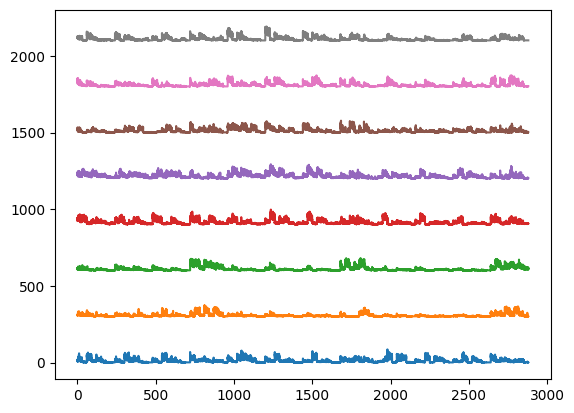

In [259]:
# plot preprocessed data
spacing = 300
window_count = arv_data.shape[0]
x = np.linspace(0, window_count * window_size / fs, window_count)

fig = plt.figure()
for i_channel in range(0, n_channels):
    plt.plot(x, arv_data[:,i_channel]+(i_channel*spacing))

In [260]:
# normalize data (scaled to range from 0 to 1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(arv_data)

In [261]:
# split data into train & test datasets
X_train, X_test, y_train, y_test = train_test_split(data_scaled, arv_labels, train_size=0.7, test_size=0.3, random_state=42, shuffle=True, stratify=arv_labels)

# split train dataset into train & validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, test_size=0.25, random_state=42, shuffle=True, stratify=y_train)

# 
# =====================
# FINAL SPLIT:
# =====================
# train - 52.5 %
# validation - 17.5 %
# test - 30 %
#

In [262]:
# definition of NN model architecture (number of layers, neurons, types of layers, layer activation functions)

model = models.Sequential()

# input layer (accepts 8 data channels)
model.add(layers.Dense(256, activation='relu', input_shape=(n_channels,)))

# hidden fully-connected (dense) layers - each neuron in current layer is connected to every neuron in the next layer
model.add(layers.Dense(256, activation='relu'))  # (added layer)
model.add(layers.Dense(128, activation='relu'))  # (added layer)
model.add(layers.Dense(128, activation='relu'))  # (added layer)
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

# output layer (transforms data into 8 possible gestures)
model.add(layers.Dense(n_gestures, activation='softmax'))

# learning rate - hyperparameter which controls how much the model needs to change in response to the estimated error each time the model's weights are updated  
learning_rate = 0.001

# optimizer/optimization algorithm (Adam - ADAptive Moment estimation) - extension of the stochastic gradient descent (SGD) but adapts learning for each model parameter
opt = keras.optimizers.Adam(learning_rate = learning_rate)

# loss function (sparse categorical cross-entropy - SCC) - computes cross-entropy loss between true labels & predicted probabilities (sparse meaning labels are provided as integers)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# metric (sparse categorical accuracy - SCA) - calculates how often predictions match integer labels (percentage of correct predictions)
metr = keras.metrics.SparseCategoricalAccuracy()

# compile model architecture
model.compile(optimizer=opt, loss=loss, metrics=[metr])

# summarize model info
model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)               │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,440 (509.53 KB)

 Trainable params: 130,440 (509.53 KB)

 Non-trainable params: 0 (0.00 B)

In [263]:
# stopping criterion to avoid overfitting
# patience hyperparameter (representing number of epochs with no improved model accuracy after which training will be prematurely stopped)
patience_epochs = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=patience_epochs)

# save best model weights
model_checkpoint = ModelCheckpoint(
        "weights.weights.h5", 
        save_best_only=True, 
        save_weights_only=True
    )


# 
# SETTING NN HYPERPARAMETERS
# 
# epoch - iteration over entire dataset
# initial epoch - epoch at which model training begins (useful for resuming previous training run)
# validation dataset - data on which model evaluates loss at the end of each epoch
# validation steps - number of steps/batches/samples to draw before stopping when performing validation at the end of each epoch (default draws validation samples until dataset exhaustion)
# batch size - number of samples per gradient update
# 

n_epochs = 100
initial_epoch = 0
batch_size = 32

# train model using train & validation datasets
history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val), 
        epochs=n_epochs, 
        batch_size=batch_size, 
        initial_epoch=initial_epoch,
        callbacks=[early_stopping, model_checkpoint]
    )

# load best weights
model.load_weights("weights.weights.h5")

Epoch 1/100


473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1180 - sparse_categorical_accuracy: 0.6057 - val_loss: 0.3691 - val_sparse_categorical_accuracy: 0.8651
Epoch 2/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2972 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.2192 - val_sparse_categorical_accuracy: 0.9306
Epoch 3/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1962 - sparse_categorical_accuracy: 0.9360 - val_loss: 0.1630 - val_sparse_categorical_accuracy: 0.9464
Epoch 4/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1572 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.1729 - val_sparse_categorical_accuracy: 0.9377
Epoch 5/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.9498 - val_loss: 0.1418 - val_sparse_categorical_accuracy: 0.9490
Epoch 6/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.9582 - val_loss: 0.1117 - val_sparse_categorical_accuracy: 0.9591
Epoch 7/10

In [264]:
# evaluate/test model on test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('MODEL ACCURACY: %.2f' % (test_accuracy * 100), '%')
print('MODEL LOSS:\t%.2f' % (test_loss * 100), '%')

MODEL ACCURACY: 98.36 %
MODEL LOSS:	6.01 %


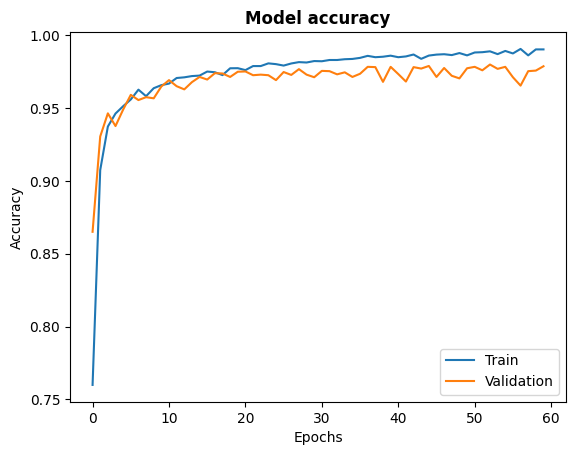

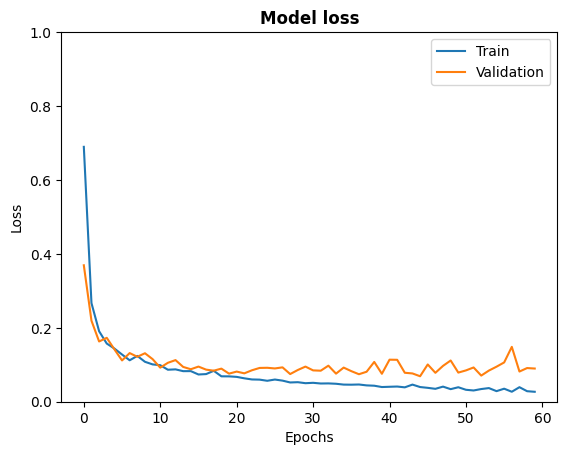

In [265]:
# plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy', fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontweight='bold')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim([0, 1])
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### Accuracy

The model's accuracy peaked at a little over 98 %, which was reached somewhere around the 60th epoch, where learning has already been prematurely stopped due to no significant improvement of loss function throughout the last 15 epochs.
In the first 5 epochs the model's accuracy seems to improve exponentially (if not factorially), but after that the accuracy improvement starts to slow down to very small improvements per epoch nearing the last epoch, but never truly plateaus, indicating the model's particularly accurate classification.

The validation accuracy seems to overlap quite well with the training accuracy, only falling slightly short of it in the last couple of epochs, while still reaching a more than 95 % accuracy.
<br/>
<hr/>

#### Loss

Model's loss function seems to be inverse to the accuracy function as it should, falling the most in the first 5 epochs and then slowing down as expected.

While training loss slowly continues to drop all throughout the learning process, the validation loss seems to obviously plateau after about the 35th epoch, soon after which the learning process prematurely stops.

The model's loss appears to reach a sub 7 % loss, which I think is reasonably good.

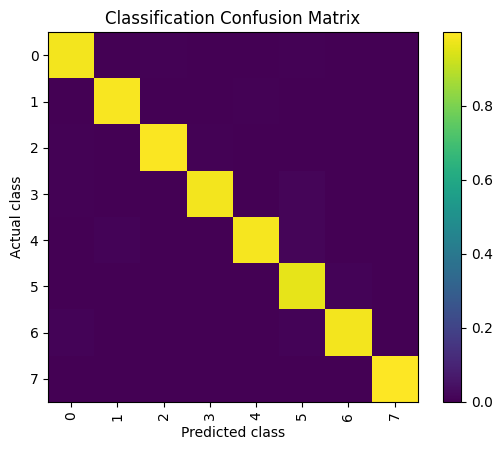

In [266]:
# model predictions for additinal analysis
predictions = model.predict(X_test, verbose=0)

# compute confusion matrix
predicted_labels = np.argmax(predictions, axis=1)
# normalize predictions for more intuitive understanding of confusion matrix
conf = confusion_matrix(y_test, predicted_labels, normalize="pred")

# visualize confusion matrix
plt.imshow(conf)
plt.title("Classification Confusion Matrix")
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.yticks(np.arange(n_gestures), gestures)
plt.xticks(np.arange(n_gestures), gestures, rotation='vertical')
plt.colorbar()

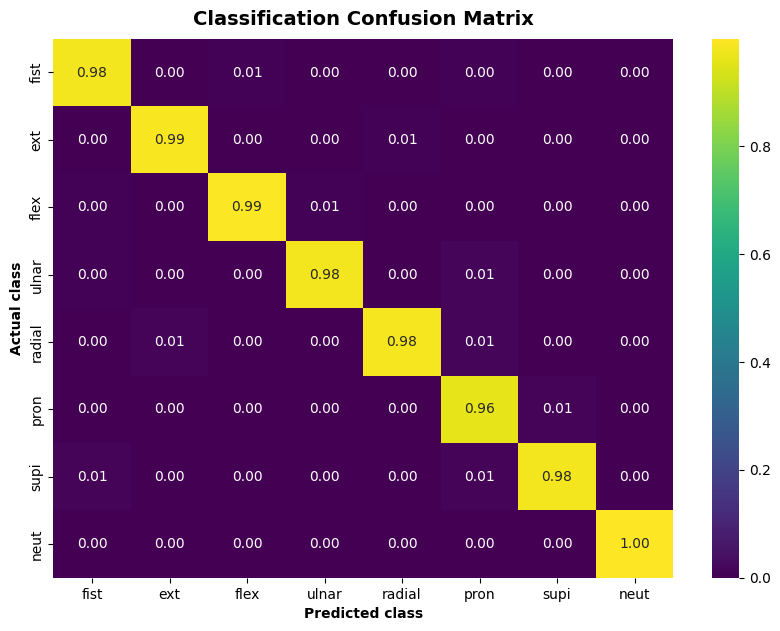

In [267]:
# more detailed visualization using Seaborn library
import seaborn as sns

descriptive_gestures = ["fist", "ext", "flex", "ulnar", "radial", "pron", "supi", "neut"]

# plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf, annot=True, fmt=".2f", cmap='viridis', 
            xticklabels=descriptive_gestures, yticklabels=descriptive_gestures)

plt.ylabel("Actual class", fontsize=10, fontweight="bold")
plt.xlabel("Predicted class", fontsize=10, fontweight="bold")
plt.title("Classification Confusion Matrix", fontsize=14, fontweight="bold", pad=10)
plt.show()

#### CONFUSION MATRIX

The model seems to correctly classify all hand movements almost all of the time, with neutral position being correctly classified 100 % of the time.

The most mixing up, which is still not anywhere near significant, seems to be happening between pronation & supination and also between radial deviation and extension (about 2 %).

In [233]:
# initialize empty datasets
data, data_labels = np.empty((0, n_channels)), np.empty((0, 1))
arv_data, arv_labels = np.empty((0, n_channels)), np.empty((0, 1))

# 
# USING ONLY MY DATA
# 

folders = ['P1/S4/', 'P2/S4/', 'P3/S4/']

# preprocessing
def calculate_arv(file_data, window_size, samples, channels):
    new_rows = samples // window_size
    arv_data = np.zeros((new_rows, channels), dtype=np.float32)
    for channel in range(channels):
        start = 0
        end = window_size
        for sample in range(new_rows):
            arv_data[sample][channel] = 1/window_size * sum(abs(file_data[start:end, channel]))
            # update moving window
            start = end
            end += window_size
    
    return arv_data


window_size = 20
for folder in folders:
    for i_gesture in range(n_gestures):
        path = f'./signals/{folder}{i_gesture}.csv'
        try:
            # read raw data from .csv file
            temp_data = pd.read_csv(path, delimiter=',', header=None).to_numpy()
            # read labels
            data_labels = np.append(data_labels, np.full((samp_for_dataset, 1), i_gesture))
            data = np.append(data, temp_data, axis=0)

            # preprocessing
            arv = calculate_arv(temp_data, window_size, n_samples, n_channels)
            arv_data = np.append(arv_data, arv, axis=0)
        except:
            print("error occurred while processing data")
            pass


# compute corresponding labels for ARV preprocessed data
for i in range(window_size, data.shape[0]+1, window_size):
    label = np.bincount(data_labels[i-window_size:i].astype(int).flatten()).argmax()
    arv_labels = np.append(arv_labels, [[label]], axis=0)

print("data shape: ", data.shape)
print("labels shape: ", data_labels.shape)
print("preprocessed data shape: ", arv_data.shape)
print("preprocessed labels shape: ", arv_labels.shape)

data shape:  (144000, 8)
labels shape:  (144000,)
preprocessed data shape:  (7200, 8)
preprocessed labels shape:  (7200, 1)


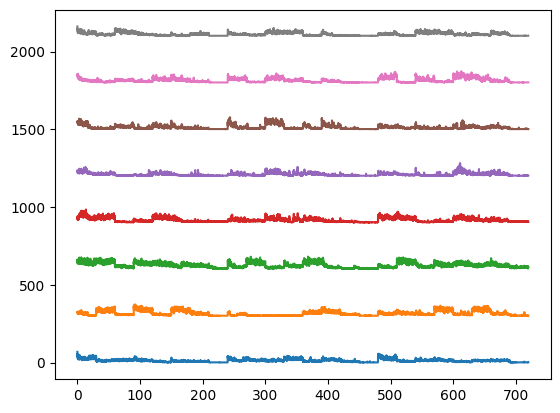

In [234]:
# plot preprocessed data
spacing = 300
window_count = arv_data.shape[0]
x = np.linspace(0, window_count * window_size / fs, window_count)

fig = plt.figure()
for i_channel in range(0, n_channels):
    plt.plot(x, arv_data[:,i_channel]+(i_channel*spacing))

In [240]:
# normalize data (scaled to range from 0 to 1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(arv_data)

In [241]:
# split data into train & test datasets
X_train, X_test, y_train, y_test = train_test_split(data_scaled, arv_labels, train_size=0.67, test_size=0.33, random_state=42, shuffle=True, stratify=arv_labels)

# split train dataset into train & validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, test_size=0.15, random_state=42, shuffle=True, stratify=y_train)

# 
# =====================
# FINAL SPLIT:
# =====================
# train - 57 %
# validation - 10 %
# test - 33 %
#

In [242]:
# definition of NN model architecture (number of layers, neurons, types of layers, layer activation functions)

model = models.Sequential()

# input layer (accepts 8 data channels)
model.add(layers.Dense(256, activation='relu', input_shape=(n_channels,)))

model.add(layers.Dense(128, activation='relu')) # (added layer)
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(32, activation='relu'))  # (added layer)
model.add(layers.Dense(16, activation='relu'))  # (added layer)


# output layer (transforms data into 8 possible gestures)
model.add(layers.Dense(n_gestures, activation='softmax'))

# learning rate - hyperparameter which controls how much the model needs to change in response to the estimated error each time the model's weights are updated  
learning_rate = 0.0008

# optimizer/optimization algorithm (Adam - ADAptive Moment estimation) - extension of the stochastic gradient descent (SGD) but adapts learning for each model parameter
opt = keras.optimizers.Adam(learning_rate = learning_rate)

# loss function (sparse categorical cross-entropy - SCC) - computes cross-entropy loss between true labels & predicted probabilities (sparse meaning labels are provided as integers)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# metric (sparse categorical accuracy - SCA) - calculates how often predictions match integer labels (percentage of correct predictions)
metr = keras.metrics.SparseCategoricalAccuracy()

# compile model architecture
model.compile(optimizer=opt, loss=loss, metrics=[metr])

# summarize model info
model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_199 (Dense)               │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,632 (174.34 KB)

 Trainable params: 44,632 (174.34 KB)

 Non-trainable params: 0 (0.00 B)

In [243]:
# stopping criterion to avoid overfitting
# patience hyperparameter (representing number of epochs with no improved model accuracy after which training will be prematurely stopped)
patience_epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=patience_epochs)

# save best model weights
model_checkpoint = ModelCheckpoint(
        "weights.weights.h5", 
        save_best_only=True, 
        save_weights_only=True
    )

# setting NN hyperparameters

# epoch - iteration over entire dataset
# initial epoch - epoch at which model training begins (useful for resuming previous training run)
# validation dataset - data on which model evaluates loss at the end of each epoch
# validation steps - number of steps/batches/samples to draw before stopping when performing validation at the end of each epoch (default draws validation samples until dataset exhaustion)
# batch size - number of samples per gradient update
n_epochs = 75
initial_epoch = 0
batch_size = 8

# train model using train & validation datasets
history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val), 
        epochs=n_epochs, 
        batch_size=batch_size, 
        initial_epoch=initial_epoch,
        callbacks=[early_stopping, model_checkpoint]
    )

# load best weights
model.load_weights("weights.weights.h5")

Epoch 1/75
513/513 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3878 - sparse_categorical_accuracy: 0.5218 - val_loss: 0.4022 - val_sparse_categorical_accuracy: 0.8564
Epoch 2/75
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3434 - sparse_categorical_accuracy: 0.8797 - val_loss: 0.2779 - val_sparse_categorical_accuracy: 0.8923
Epoch 3/75
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2088 - sparse_categorical_accuracy: 0.9251 - val_loss: 0.2020 - val_sparse_categorical_accuracy: 0.9392
Epoch 4/75
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1823 - sparse_categorical_accuracy: 0.9373 - val_loss: 0.1814 - val_sparse_categorical_accuracy: 0.9475
Epoch 5/75
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1381 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.1679 - val_sparse_categorical_accuracy: 0.9448
Epoch 6/75
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1342 - sparse_categorical_accuracy: 0.9527 - val_loss: 0.1538 - val_sparse_categorical_accuracy: 0.9544
Epoc

In [245]:
# evaluate/test model on test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('MODEL ACCURACY: %.2f' % (test_accuracy * 100), '%')
print('MODEL LOSS:\t%.2f' % (test_loss * 100), '%')

MODEL ACCURACY: 98.06 %
MODEL LOSS:	6.97 %


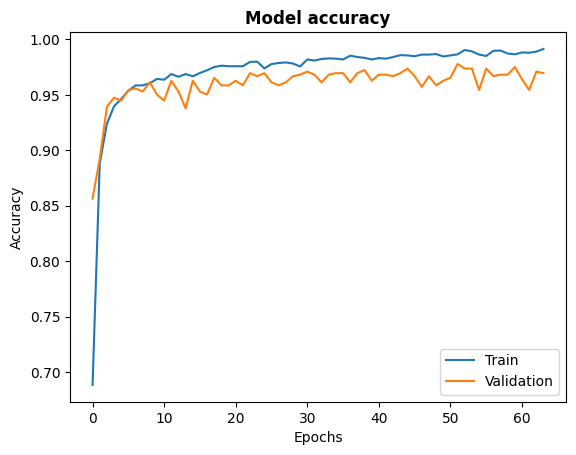

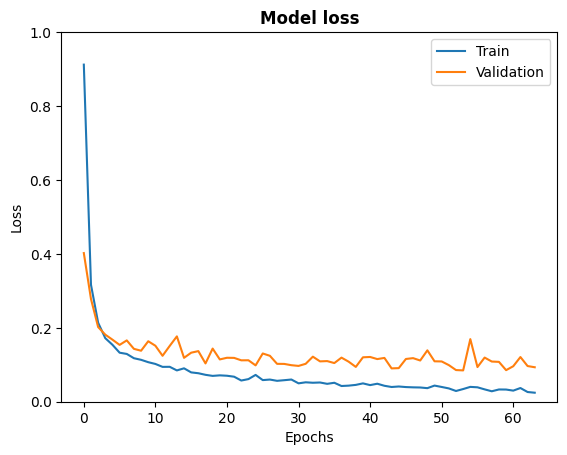

In [246]:
# plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy', fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontweight='bold')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim([0, 1])
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### Accuracy

The model's peak accuracy is a bit less than 98 %, which is reached somewhere around the 60th epoch, where learning has already been prematurely stopped due to no significant improvement of loss function throughout the last 15 epochs.

Overall results seem to be very similator to those performed using a larger dataset, however these results reach a bit of a less impressive accuracy, although it isn't a very noticeable decrease.

The validation accuracy seems to overlap quite well with the training accuracy in the first couple of epochs, before plateauing a bit under the training accuracy.
<br/>
<hr/>

#### Loss

Here, the validation loss seems to be plateuaing a bit more significantly, indicating a possible overfitting or overlearning of the model.

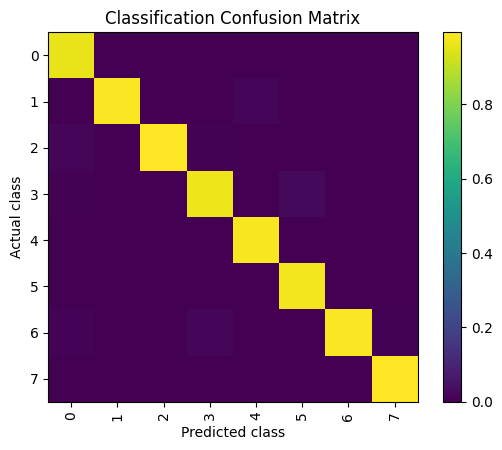

In [247]:
# model predictions for additinal analysis
predictions = model.predict(X_test, verbose=0)

# compute confusion matrix
predicted_labels = np.argmax(predictions, axis=1)
# normalize predictions for more intuitive understanding of confusion matrix
conf = confusion_matrix(y_test, predicted_labels, normalize="pred")

# visualize confusion matrix
plt.imshow(conf)
plt.title("Classification Confusion Matrix")
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.yticks(np.arange(n_gestures), gestures)
plt.xticks(np.arange(n_gestures), gestures, rotation='vertical')
plt.colorbar()

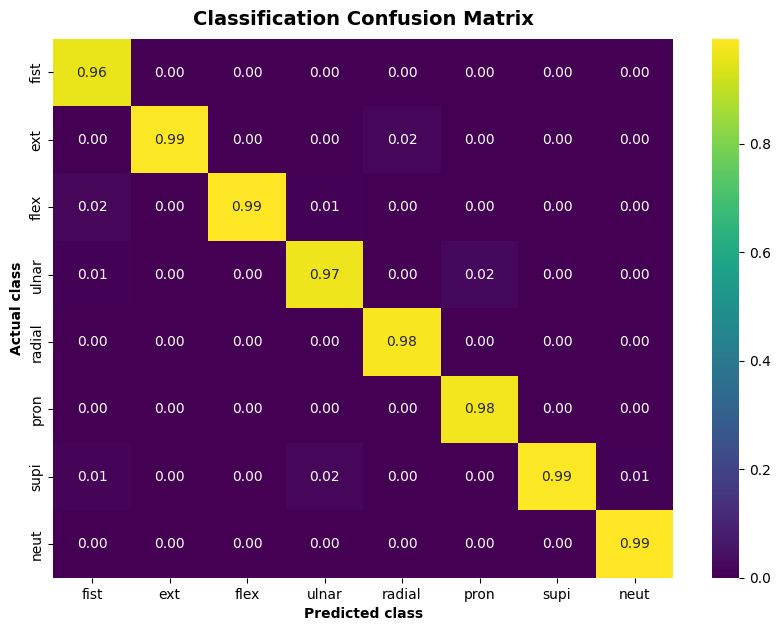

In [248]:
# more detailed visualization using Seaborn library
import seaborn as sns

descriptive_gestures = ["fist", "ext", "flex", "ulnar", "radial", "pron", "supi", "neut"]

# plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf, annot=True, fmt=".2f", cmap='viridis', 
            xticklabels=descriptive_gestures, yticklabels=descriptive_gestures)

plt.ylabel("Actual class", fontsize=10, fontweight="bold")
plt.xlabel("Predicted class", fontsize=10, fontweight="bold")
plt.title("Classification Confusion Matrix", fontsize=14, fontweight="bold", pad=10)
plt.show()

#### CONFUSION MATRIX:

Interestingly enough, the most consufion here seems to be between extension and radial deviation, reaching 3 %, while confusion between pronation and supination isn't as prominent here as it was on a larger dataset, which I don't think is to be expected.

In [89]:
# initialize empty datasets
data, data_labels = np.empty((0, n_channels)), np.empty((0, 1))
arv_data, arv_labels = np.empty((0, n_channels)), np.empty((0, 1))

# 
# USING ALL AVAILABLE DATA
# 

folders = [ 'P1/S1/',
            'P1/S2/',
            'P1/S3/',
            'P1/S4/',
            'P2/S1/',
            'P2/S2/',
            'P2/S3/',
            'P2/S4/',
            'P3/S1/',
            'P3/S2/',
            'P3/S3/',
            'P3/S4/',
            ]

# preprocessing
def calculate_arv(file_data, window_size, samples, channels):
    new_rows = samples // window_size
    arv_data = np.zeros((new_rows, channels), dtype=np.float32)
    for channel in range(channels):
        start = 0
        end = window_size
        for sample in range(new_rows):
            arv_data[sample][channel] = 1/window_size * sum(abs(file_data[start:end, channel]))
            # update moving window
            start = end
            end += window_size
    
    return arv_data


window_size = 20
for folder in folders:
    for i_gesture in range(n_gestures):
        path = f'./signals/{folder}{i_gesture}.csv'
        try:
            # read raw data from .csv file
            temp_data = pd.read_csv(path, delimiter=',', header=None).to_numpy()
            # read labels
            data_labels = np.append(data_labels, np.full((samp_for_dataset, 1), i_gesture))
            data = np.append(data, temp_data, axis=0)

            # preprocessing
            arv = calculate_arv(temp_data, window_size, n_samples, n_channels)
            arv_data = np.append(arv_data, arv, axis=0)
        except:
            print("error occurred while processing data")
            pass


# compute corresponding labels for ARV preprocessed data
for i in range(window_size, data.shape[0]+1, window_size):
    label = np.bincount(data_labels[i-window_size:i].astype(int).flatten()).argmax()
    arv_labels = np.append(arv_labels, [[label]], axis=0)

print("data shape: ", data.shape)
print("labels shape: ", data_labels.shape)
print("preprocessed data shape: ", arv_data.shape)
print("preprocessed labels shape: ", arv_labels.shape)

data shape:  (576000, 8)
labels shape:  (576000,)
preprocessed data shape:  (28800, 8)
preprocessed labels shape:  (28800, 1)


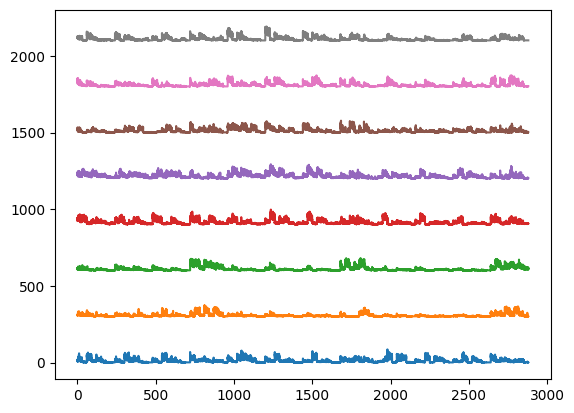

In [90]:
# plot preprocessed data
spacing = 300
window_count = arv_data.shape[0]
x = np.linspace(0, window_count * window_size / fs, window_count)

fig = plt.figure()
for i_channel in range(0, n_channels):
    plt.plot(x, arv_data[:,i_channel]+(i_channel*spacing))

In [91]:
# normalize data (scaled to range from 0 to 1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(arv_data)

In [92]:
# split data into train & test datasets (SVM classifier does not accept a validation dataset)
X_train, X_test, y_train, y_test = train_test_split(data_scaled, arv_labels, train_size=0.7, test_size=0.3, random_state=42, shuffle=True, stratify=arv_labels)

# 
# =====================
# FINAL SPLIT:
# =====================
# train - 70 %
# test - 30 %
#

In [93]:
from sklearn.model_selection import GridSearchCV

# testing multiple combinations of SVM hyperparameters for best classification results
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}

# 
# C - regularization parameter --> controls trade-off between maximizing margin & minimizing classification error
#                                  smaller C - makes decision surface smoother, but may result in misclassification
#                                  larger C - aims to classify all training examples correctly, but may result in overfitting
# 
# Gamma - kernel coefficient --> defines how far the influence of a single training example reaches
#                                larger Gamma - classifier will consider only nearby points, leading to a more complex model and potential overfitting
#                                smaller Gamma - classifier will consider points far away from decision boundary, leading to a simpler model
# 
# Kernel --> specifies type of kernel function to be used in the learning algorithm, determines decision boundary and classifier performance
#            Linear - simple linear separator (binary classification)
#            Polynomial - polynomial kernel (higher order classifications)
#            RBF (Radial Basis Function) - Gaussian kernel (default/most commonly used)
#            Sigmoid - sigmoid kernel, similar to a NN activation function inside neuron layers
# 


grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train, y_train)

print("\nBEST SVM HYPERPARAMETERS: ", grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  21.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  21.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  23.8s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  21.8s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  20.9s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   4.6s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   4.5s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   4.5s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   4.5s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   4.6s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  21.8s
[CV] END ......................C=0.1, gamma=0.0

In [94]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# initialize the SVM classifier
svm_classifier = SVC(kernel='rbf', C=10, gamma=10)

# train classifier
svm_classifier.fit(X_train, y_train)

SVC(C=10, gamma=10)

In [95]:
# predict results on test set
y_pred = svm_classifier.predict(X_test)

# evaluate classifier accuracy
accuracy = accuracy_score(y_test, y_pred)
print('CLASSIFIER ACCURACY: %.2f' % (accuracy * 100), '%\n')

# print detailed classification report (precision, recall, f1-score, support)
print(classification_report(y_test, y_pred))

# print confusion matrix using terminal
print("CONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred))

CLASSIFIER ACCURACY: 97.87 %

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1080
         1.0       0.98      0.98      0.98      1080
         2.0       0.99      0.99      0.99      1080
         3.0       0.98      0.99      0.98      1080
         4.0       0.98      0.96      0.97      1080
         5.0       0.95      0.97      0.96      1080
         6.0       0.98      0.96      0.97      1080
         7.0       1.00      1.00      1.00      1080

    accuracy                           0.98      8640
   macro avg       0.98      0.98      0.98      8640
weighted avg       0.98      0.98      0.98      8640

CONFUSION MATRIX:
[[1060    0    6    4    2    7    1    0]
 [   0 1062    0    0   10    6    2    0]
 [   6    0 1067    5    0    0    2    0]
 [   5    1    0 1065    0    7    2    0]
 [   6   22    0    3 1037    9    3    0]
 [   2    0    2    6    8 1049   13    0]
 [   9    0    1    4    3   22 1040    1]


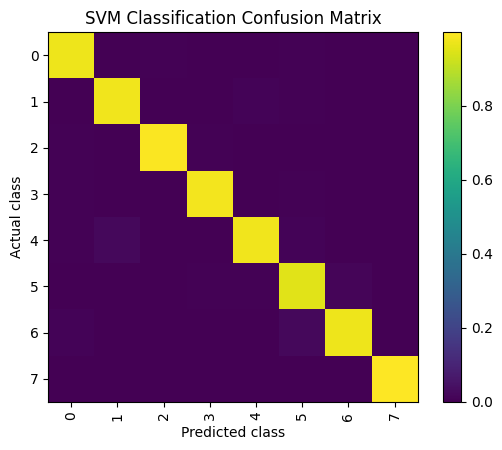

In [96]:
# compute the confusion matrix
conf = confusion_matrix(y_test, y_pred, normalize="pred")

# display confusion matrix visually
plt.imshow(conf)
plt.title("SVM Classification Confusion Matrix")
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.yticks(np.arange(n_gestures), gestures)
plt.xticks(np.arange(n_gestures), gestures, rotation='vertical')
plt.colorbar()
plt.show()

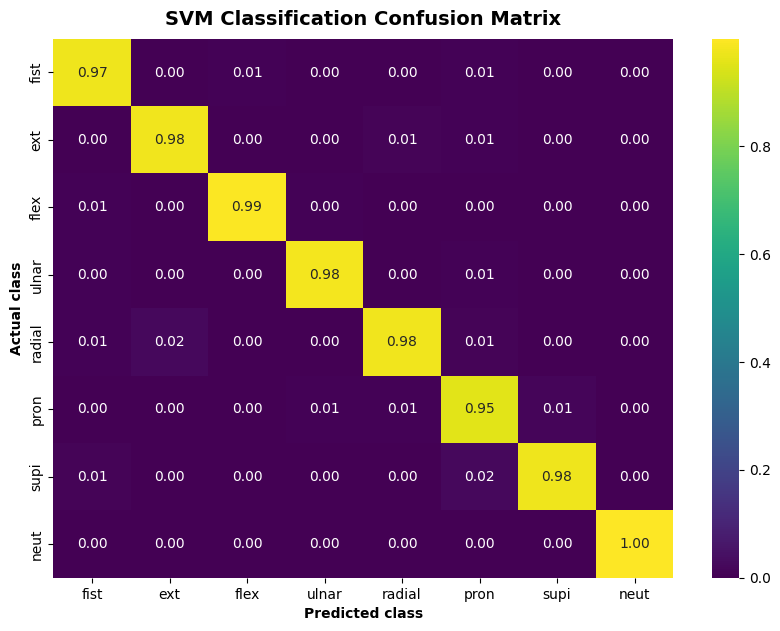

In [97]:
# more detailed visualization using Seaborn library
import seaborn as sns

descriptive_gestures = ["fist", "ext", "flex", "ulnar", "radial", "pron", "supi", "neut"]

plt.figure(figsize=(10, 7))
sns.heatmap(conf, annot=True, fmt=".2f", cmap='viridis', 
            xticklabels=descriptive_gestures, yticklabels=descriptive_gestures)

plt.ylabel("Actual class", fontsize=10, fontweight="bold")
plt.xlabel("Predicted class", fontsize=10, fontweight="bold")
plt.title("SVM Classification Confusion Matrix", fontsize=14, fontweight="bold", pad=10)
plt.show()

In [5]:
# initialize empty datasets
data, data_labels = np.empty((0, n_channels)), np.empty((0, 1))
arv_data, arv_labels = np.empty((0, n_channels)), np.empty((0, 1))

# 
# USING ONLY MY DATA
# 

folders = ['P1/S4/', 'P2/S4/', 'P3/S4/']

# preprocessing
def calculate_arv(file_data, window_size, samples, channels):
    new_rows = samples // window_size
    arv_data = np.zeros((new_rows, channels), dtype=np.float32)
    for channel in range(channels):
        start = 0
        end = window_size
        for sample in range(new_rows):
            arv_data[sample][channel] = 1/window_size * sum(abs(file_data[start:end, channel]))
            # update moving window
            start = end
            end += window_size
    
    return arv_data


window_size = 20
for folder in folders:
    for i_gesture in range(n_gestures):
        path = f'./signals/{folder}{i_gesture}.csv'
        try:
            # read raw data from .csv file
            temp_data = pd.read_csv(path, delimiter=',', header=None).to_numpy()
            # read labels
            data_labels = np.append(data_labels, np.full((samp_for_dataset, 1), i_gesture))
            data = np.append(data, temp_data, axis=0)

            # preprocessing
            arv = calculate_arv(temp_data, window_size, n_samples, n_channels)
            arv_data = np.append(arv_data, arv, axis=0)
        except:
            print("error occurred while processing data")
            pass


# compute corresponding labels for ARV preprocessed data
for i in range(window_size, data.shape[0]+1, window_size):
    label = np.bincount(data_labels[i-window_size:i].astype(int).flatten()).argmax()
    arv_labels = np.append(arv_labels, [[label]], axis=0)

print("data shape: ", data.shape)
print("labels shape: ", data_labels.shape)
print("preprocessed data shape: ", arv_data.shape)
print("preprocessed labels shape: ", arv_labels.shape)

data shape:  (144000, 8)
labels shape:  (144000,)
preprocessed data shape:  (7200, 8)
preprocessed labels shape:  (7200, 1)


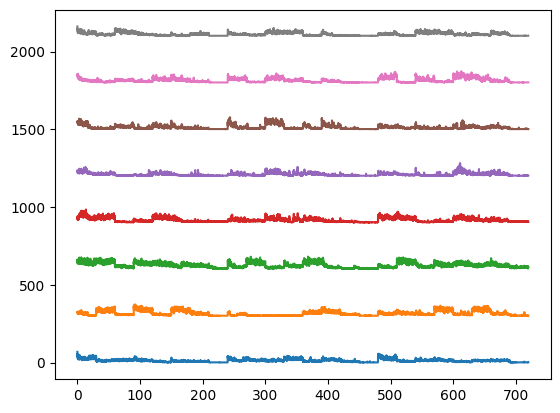

In [6]:
# plot preprocessed data
spacing = 300
window_count = arv_data.shape[0]
x = np.linspace(0, window_count * window_size / fs, window_count)

fig = plt.figure()
for i_channel in range(0, n_channels):
    plt.plot(x, arv_data[:,i_channel]+(i_channel*spacing))

In [7]:
# normalize data (scaled to range from 0 to 1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(arv_data)

In [8]:
# split data into train & test datasets (SVM classificator does not accept a validation dataset)
X_train, X_test, y_train, y_test = train_test_split(data_scaled, arv_labels, train_size=0.7, test_size=0.3, random_state=42, shuffle=True, stratify=arv_labels)

# 
# =====================
# FINAL SPLIT:
# =====================
# train - 70 %
# test - 30 %
#

In [9]:
from sklearn.model_selection import GridSearchCV

# testing multiple combinations of SVM hyperparameters for best classification results
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}

# 
# C - regularization parameter --> controls trade-off between maximizing margin & minimizing classification error
#                                  smaller C - makes decision surface smoother, but may result in misclassification
#                                  larger C - aims to classify all training examples correctly, but may result in overfitting
# 
# Gamma - kernel coefficient --> defines how far the influence of a single training example reaches
#                                larger Gamma - classifier will consider only nearby points, leading to a more complex model and potential overfitting
#                                smaller Gamma - classifier will consider points far away from decision boundary, leading to a simpler model
# 
# Kernel --> specifies type of kernel function to be used in the learning algorithm, determines decision boundary and classifier performance
#            Linear - simple linear separator (binary classification)
#            Polynomial - polynomial kernel (higher order classifications)
#            RBF (Radial Basis Function) - Gaussian kernel (default/most commonly used)
#            Sigmoid - sigmoid kernel, similar to a NN activation function inside neuron layers
# 


grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train, y_train)

print("\nBEST SVM HYPERPARAMETERS: ", grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.1s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.0s
[CV] END ......................C=0.1, gamma=0.0

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# initialize the SVM classifier
svm_classifier = SVC(kernel='rbf', C=10, gamma=10)

# train classifier
svm_classifier.fit(X_train, y_train)

SVC(C=10, gamma=10)

In [11]:
# predict results on test set
y_pred = svm_classifier.predict(X_test)

# evaluate classifier accuracy
accuracy = accuracy_score(y_test, y_pred)
print('CLASSIFIER ACCURACY: %.2f' % (accuracy * 100), '%\n')

# print detailed classification report (precision, recall, f1-score, support)
print(classification_report(y_test, y_pred))

# print confusion matrix using terminal
print("CONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred))

CLASSIFIER ACCURACY: 97.92 %

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       270
         1.0       0.98      0.98      0.98       270
         2.0       1.00      0.99      0.99       270
         3.0       0.96      0.97      0.96       270
         4.0       0.99      0.98      0.98       270
         5.0       0.98      0.99      0.99       270
         6.0       0.96      0.97      0.97       270
         7.0       0.99      0.99      0.99       270

    accuracy                           0.98      2160
   macro avg       0.98      0.98      0.98      2160
weighted avg       0.98      0.98      0.98      2160

CONFUSION MATRIX:
[[262   2   0   5   1   0   0   0]
 [  2 265   0   1   2   0   0   0]
 [  2   0 267   0   0   0   1   0]
 [  1   1   0 261   0   4   3   0]
 [  1   3   0   0 264   1   1   0]
 [  0   0   0   1   0 268   1   0]
 [  2   0   1   3   0   0 262   2]
 [  0   0   0   0   0   0   4 266]]


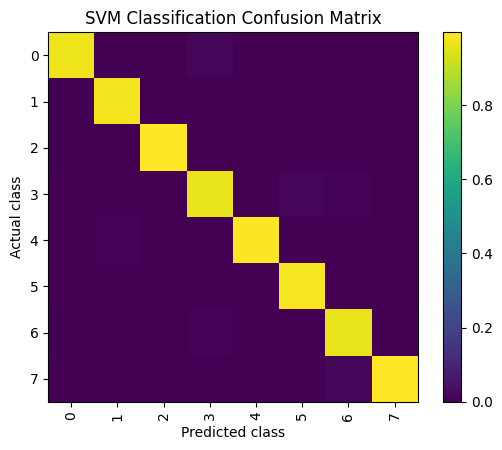

In [12]:
# compute the confusion matrix
conf = confusion_matrix(y_test, y_pred, normalize="pred")

# display confusion matrix visually
plt.imshow(conf)
plt.title("SVM Classification Confusion Matrix")
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.yticks(np.arange(n_gestures), gestures)
plt.xticks(np.arange(n_gestures), gestures, rotation='vertical')
plt.colorbar()
plt.show()

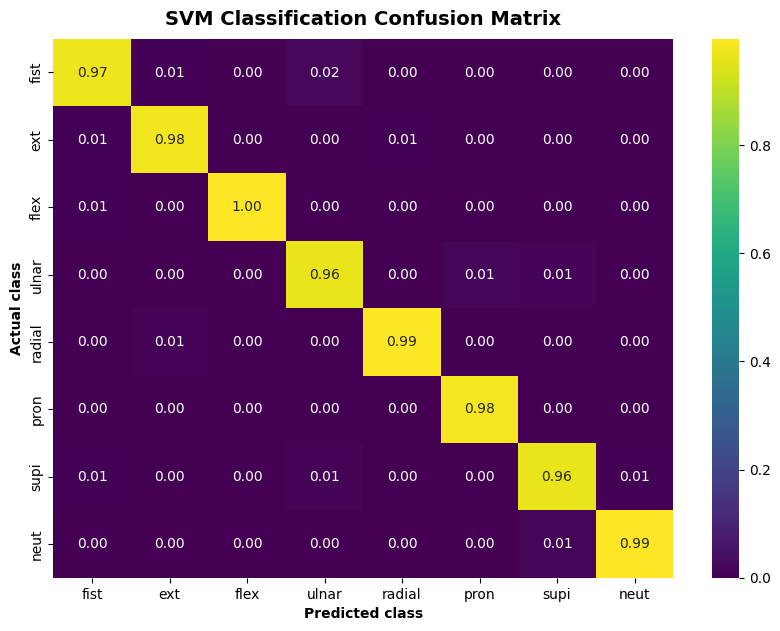

In [13]:
# more detailed visualization using Seaborn library
import seaborn as sns

descriptive_gestures = ["fist", "ext", "flex", "ulnar", "radial", "pron", "supi", "neut"]

plt.figure(figsize=(10, 7))
sns.heatmap(conf, annot=True, fmt=".2f", cmap='viridis', 
            xticklabels=descriptive_gestures, yticklabels=descriptive_gestures)

plt.ylabel("Actual class", fontsize=10, fontweight="bold")
plt.xlabel("Predicted class", fontsize=10, fontweight="bold")
plt.title("SVM Classification Confusion Matrix", fontsize=14, fontweight="bold", pad=10)
plt.show()

#### SVM CLASSIFIER

For both the larger and the smaller datasets, the most optimal hyperparameters seem to be C = 10 and Gamma = 10, using the RBF kernel. Both examples of classification produced results which were just a bit short of 98 % accuracy.